In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import localSettings as ls
import math
print(ls.main_path)


/Users/elenag/Desktop/PlotterLEE/


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 05132021


In [5]:
SHRCALIBFACTOR = 1.00
# USING BDT?
USEBDT = True

In [6]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [7]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)



In [8]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return dot_product # angle*180/3.14159265


angleFromNuMITarget(1,1,1,1.4,3.)

-0.29381557377862155

In [9]:
tree = "NeutrinoSelectionFilter"

NUENuMI  = 'fullDataSets/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
NUENuMI  =  'parent/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune
NUEBNB   = 'bnb/prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2'+ls.APPEND #newTune

bnb   = uproot.open(ls.ntuple_path+NUEBNB +".root")[ls.fold][tree]
numi  = uproot.open(ls.ntuple_path+NUENuMI+".root")[ls.fold][tree]


uproot_v = [bnb, numi] 

variables = ["run", "sub", "evt", "nu_pdg","shr_tkfit_nhits_Y", "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_dedx_Y", 
             "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", 
             "shr_tkfit_2cm_nhits_Y", "shr_tkfit_2cm_nhits_U", "shr_tkfit_2cm_nhits_V", 
             "shr_tkfit_2cm_dedx_Y", "shr_tkfit_2cm_dedx_U", "shr_tkfit_2cm_dedx_V",             
             "shr_energy_tot_cali", "trk_energy_tot", "shr_energy", "shr_theta", "trk_theta_v", "trk_phi_v", 
             "trk_score_v", "trk_llr_pid_score_v", "topological_score","trk_energy_proton_v", "trk_calo_energy_y_v", "trk_id", 
             "n_tracks_contained", "shrsubclusters0", "shrsubclusters1", "shrsubclusters2", 
             "shr_tkfit_npointsvalid", "shr_tkfit_npoints", "secondshower_Y_dir", "shrclusdir2", "trk_theta", 
             "trk_sce_start_x_v", "trk_sce_start_y_v", "trk_sce_start_z_v", 
             "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", 
             "shrmoliereavg", "secondshower_Y_dot", "true_e_visible",
             "pfnhits", "pfnunhits", "flash_time", "category", "shr_score", "tksh_distance","interaction", "tksh_angle",
             "trkshrhitdist2", "hits_ratio", "secondshower_Y_nhit", "secondshower_Y_vtxdist", "CosmicIPAll3D", 
             "CosmicDirAll3D", "nslice", "selected", "_opfilter_pe_beam", "_opfilter_pe_veto", "n_showers_contained", 
             "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", 
             "pt", "shr_phi", "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
             "shr_tkfit_gap10_dedx_Y", "shr_tkfit_gap10_dedx_U", "shr_tkfit_gap10_dedx_V",
             "slnunhits","slnhits","pi0_e","ccnc","shr_pz","shr_py","shr_px","npi0","isVtxInFiducial","truthFiducial","ccnc","npi0","npion","nproton"]



varMC = ["elec_px","elec_py","elec_pz","nu_decay_mode","nu_e","true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
"]#,"true_nu_px","true_nu_py","true_nu_pz"]

#make the list unique
variables = list(set(variables))
print(variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX',"ppfx_cv","par_decay_vx", "par_decay_vy", "par_decay_vz", "par_decay_px", "par_decay_py", "par_decay_pz","baseline"]




WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]



bnb   = bnb.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS +varMC, flatten=False)
numi  = numi.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+varMC, flatten=False)


['nu_pdg', 'reco_nu_vtx_sce_z', 'trk_phi_v', 'shr_energy', 'true_e_visible', 'trk_sce_start_y_v', 'interaction', 'shr_tkfit_gap10_dedx_Y', 'shr_tkfit_2cm_nhits_Y', 'truthFiducial', 'run', '_opfilter_pe_beam', 'sub', 'pt', 'pi0_e', 'trk_id', 'pfnunhits', 'isVtxInFiducial', 'shr_tkfit_npointsvalid', 'shr_tkfit_npoints', 'shr_energy_tot_cali', 'shr_tkfit_gap10_nhits_U', 'shr_tkfit_nhits_Y', 'shr_tkfit_gap10_nhits_V', 'shr_tkfit_nhits_U', 'shr_tkfit_dedx_Y', 'ccnc', 'nslice', 'trk_theta_v', 'flash_time', 'reco_nu_vtx_sce_y', 'trk_score_v', 'pfnhits', 'trk_calo_energy_y_v', 'shr_score', 'secondshower_Y_nhit', 'shr_tkfit_2cm_nhits_U', 'shr_px', 'shr_tkfit_2cm_dedx_Y', 'shr_pz', 'trk_energy_proton_v', 'shr_py', 'npi0', '_opfilter_pe_veto', 'shr_tkfit_2cm_dedx_V', 'shr_tkfit_2cm_nhits_V', 'nproton', 'trk_llr_pid_score_v', 'evt', 'slnunhits', 'shrsubclusters0', 'secondshower_Y_dot', 'trk_sce_start_x_v', 'shrmoliereavg', 'trk_theta', 'slnhits', 'trk_sce_end_x_v', 'tksh_angle', 'shr_tkfit_2cm_ded

In [10]:
df_v = [numi]
for i,df in enumerate(df_v):
    df[ 'LOverE' ] =     df[ 'baseline' ]/ df[ 'nu_e' ]
    
df_v = [bnb]
for i,df in enumerate(df_v):
    df[ 'LOverE' ] =     479./ df[ 'nu_e' ]
    

In [11]:
df_v = [bnb, numi]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [12]:
df_v = [numi]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']



In [13]:
df_v = [bnb]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    
    # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

for i,df in enumerate(df_v):
    df[ 'currentweight' ]      = df['weightSplineTimesTune']
    df[ 'currentweightsafe' ]  = df['weightSplineTimesTune']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTune']
    df[ 'currentweight2' ]     = df['weightSplineTimesTune']


In [14]:
df_v = [numi]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 

        
df_v = [bnb]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTune' ] =  (df['weightSplineTimesTune'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTune'] = df['weightSplineTimesTune']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 



In [15]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!
import time
s = time.time()


df_v = [bnb, numi]
puppa1 = 'trk_score_v'
#print ('trk_llr_pid_score_v' in nue.columns.to_list())


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    print(trk_score_v.shape, len(trk_llr_pid_v))
#    print(len(c), len(trk_id), len(trk_llr_pid_v))
#    for pidv,puppa,tid,cid in zip(trk_llr_pid_v,trk_score_puppa_v,trk_id,c):
#        if len(pidv) > 0:
#            print(len(pidv),len(puppa), pidv,puppa,tid,cid )
#    nnnnnnnPupppppppaaa = 0
#    print(type(trk_llr_pid_v), trk_llr_pid_v.shape)
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    #df['n_proton_cand']   = puppa_proton
    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel


    #print(  df['N_recoShowers'])

for i,df in enumerate(df_v):
    df['shr_numi_Angle']        = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle']     = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)
    df['shr_Angle_Numi_target'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['proton_Angle_Numi_target'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['protontheta'],x['protonphi']) , axis=1)
s2 = time.time()
print (s-s2)

(88563,) 88563
(127339,) 127339


/Users/elenag/miniconda3/envs/peleeNB/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


-162.3005850315094


In [16]:
df_v = [bnb, numi]
for i,df in enumerate(df_v):
    up = uproot_v[i]
    #trk_score_v = up.array('trk_score_v')
    trk_sce_start_x_v = up.array('trk_sce_start_x_v')
    trk_sce_start_y_v = up.array('trk_sce_start_y_v')
    trk_sce_start_z_v = up.array('trk_sce_start_z_v')
    trk_sce_end_x_v = up.array('trk_sce_end_x_v')
    trk_sce_end_y_v = up.array('trk_sce_end_y_v')
    trk_sce_end_z_v = up.array('trk_sce_end_z_v')
    shr_id = up.array('shr_id')-1 # I think we need this -1 to get the right result
    #trk_score_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_score_v,shr_id)])
    trk_sce_start_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_x_v,shr_id)])
    trk_sce_start_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_y_v,shr_id)])
    trk_sce_start_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_start_z_v,shr_id)])
    trk_sce_end_x_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_x_v,shr_id)])
    trk_sce_end_y_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_y_v,shr_id)])
    trk_sce_end_z_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else -9999. for pidv,tid in zip(trk_sce_end_z_v,shr_id)])
    #df['shr_score_check'] = trk_score_v_sel
    df['shr_trk_sce_start_x'] = trk_sce_start_x_v_sel
    df['shr_trk_sce_start_y'] = trk_sce_start_y_v_sel
    df['shr_trk_sce_start_z'] = trk_sce_start_z_v_sel
    df['shr_trk_sce_end_x'] = trk_sce_end_x_v_sel
    df['shr_trk_sce_end_y'] = trk_sce_end_y_v_sel
    df['shr_trk_sce_end_z'] = trk_sce_end_z_v_sel   

In [17]:
df_v = [bnb, numi]
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [18]:

for i,df in enumerate(df_v):
    up = uproot_v[i]
    df["slclnhits"]   = up.array("pfnhits").sum()
    df["slclnunhits"] = up.array("pfnunhits").sum()
#

In [19]:
df_v = [bnb, numi]
for i,df in enumerate(df_v):
    df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])
    df['shr_tkfit_nhi'] = (df['shr_tkfit_nhits_Y']*df['shr_tkfit_dedx_Y'] + df['shr_tkfit_nhits_U']*df['shr_tkfit_dedx_U'] + df['shr_tkfit_nhits_V']*df['shr_tkfit_dedx_V'])/df['shr_tkfit_nhits_tot']
    df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])
    df['shr_tkfit_2cm_dedx_avg'] = (df['shr_tkfit_2cm_nhits_Y']*df['shr_tkfit_2cm_dedx_Y'] + df['shr_tkfit_2cm_nhits_U']*df['shr_tkfit_2cm_dedx_U'] + df['shr_tkfit_2cm_nhits_V']*df['shr_tkfit_2cm_dedx_V'])/df['shr_tkfit_2cm_nhits_tot']
    df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])
    df['shr_tkfit_gap10_dedx_avg'] = (df['shr_tkfit_gap10_nhits_Y']*df['shr_tkfit_gap10_dedx_Y'] + df['shr_tkfit_gap10_nhits_U']*df['shr_tkfit_gap10_dedx_U'] + df['shr_tkfit_gap10_nhits_V']*df['shr_tkfit_gap10_dedx_V'])/df['shr_tkfit_gap10_nhits_tot']
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [20]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [21]:
# add back the cosmic category, for background only
df_v = [bnb, numi]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4

In [22]:
#reset timing
df_v = [bnb, numi]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304



In [23]:
bnb["is_signal"]  = bnb["category"] == 11
numi["is_signal"] = numi["category"] == 11

In [24]:
# variables to be trained on
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max","trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

In [25]:
LABELS = ['pi0','nonpi0']

if (USEBDT == True):
    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304_extnumi.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            bnb[label+"_score"] = booster.predict(
                xgb.DMatrix(bnb[TRAINVAR]),
                ntree_limit=booster.best_iteration)
            numi[label+"_score"] = booster.predict(
                xgb.DMatrix(numi[TRAINVAR]),
                ntree_limit=booster.best_iteration)


In [26]:
# Calculate the true neutrino direction off of the NuMI beam
dfmc_v = [bnb, numi]
for i,df in enumerate(dfmc_v):
    df['flux'] = np.zeros_like(df['nslice'])
    df.loc[ (((df['nu_pdg'] == 12) | (df['nu_pdg'] == -12)) & (df['nu_decay_mode'] < 11)) , 'flux'] = 10
    df.loc[ (((df['nu_pdg'] == 12) | (df['nu_pdg'] == -12)) & (df['nu_decay_mode'] > 10)) , 'flux'] = 1
    df.loc[ (((df['nu_pdg'] == 14) | (df['nu_pdg'] == -14)) & (df['nu_decay_mode'] < 11)) , 'flux'] = 10
    df.loc[ (((df['nu_pdg'] == 14) | (df['nu_pdg'] == -14)) & (df['nu_decay_mode'] > 10)) , 'flux'] = 1

In [27]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    #print("p",p)
    #print(px)
    #print(py)
    #print(pz)
    return( px.sum(), py.sum(), pz.sum())

df_v = [bnb, numi]

for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    shr_px_v            = up.array('shr_px')
    shr_py_v            = up.array('shr_py')
    shr_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    #print(proton_mask_v)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, shr_px_v,shr_py_v,shr_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] #sx +
        nu_reco_py = tempMom[1] #sy + 
        nu_reco_pz = tempMom[2] #sz + 
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)
        '''
        print("tempMom",tempMom)
        sillyCount +=1
        if sillyCount > 10:
            break
        '''
    print(len(listPx), df.shape)
    df['nu_reco_px']  = listPx
    df['nu_reco_py']  = listPy
    df['nu_reco_pz']  = listPz
    df['newP']    = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'] + df['nu_reco_pz']*df['nu_reco_pz'])
    df['newPt']   = np.sqrt(df['nu_reco_px']*df['nu_reco_px'] + df['nu_reco_py']*df['nu_reco_py'])
    #df['checkP']  = df['newP'] - df['P']
    df['checkPt'] = df['newPt'] - df['pt']



/Users/elenag/miniconda3/envs/peleeNB/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  


88563 (88563, 174)
127339 (127339, 185)


# Plotting part

In [28]:
import plotter
import importlib
importlib.reload(plotter)

<module 'plotter' from '/Users/elenag/Desktop/PlotterLEE/PELEE4/plotter.py'>

In [29]:
# muon selection
QUERY = 'nslice == 1'
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
# 1eNp preselection
NPPRESQ = PRESQ
NPPRESQ += ' and n_tracks_contained > 0'
# very loose box cuts
NPVLCUTQ = NPPRESQ
NPVLCUTQ += ' and CosmicIPAll3D > 10.'
NPVLCUTQ += ' and trkpid < 0.25'
NPVLCUTQ += ' and hits_ratio > 0.5'
NPVLCUTQ += ' and trkfit < 0.90'
NPVLCUTQ += ' and n_showers_contained == 1'
NPVLCUTQ += ' and tksh_distance < 10.0'
NPVLCUTQ += ' and tksh_angle > -0.9'
# loose box cuts
NPLCUTQ = NPVLCUTQ
NPLCUTQ += ' and CosmicIPAll3D > 10.'
NPLCUTQ += ' and trkpid < 0.02'
NPLCUTQ += ' and hits_ratio > 0.50'
NPLCUTQ += ' and shrmoliereavg < 9'
NPLCUTQ += ' and subcluster > 4'
NPLCUTQ += ' and trkfit < 0.65'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5)'
NPLCUTQ += ' and secondshower_Y_nhit < 50'
NPLCUTQ += ' and tksh_angle > -0.9'
# BDT cuts
# 0304 extnumi, pi0 and nonpi0
BDTCQ = NPPRESQ
BDTCQ += ' and pi0_score > 0.67 and nonpi0_score > 0.70'



In [30]:
QUERY = NPLCUTQ +" and "+ BDTCQ #PI0SEL#NUMUOnTheFly + ' and n_showers_contained == 1'  #PI0SEL#NPLCUTQ2 #NPLCUTQ #NPPRESQ#'nslice ==1 ' #NPPRESQ #PRESQ


In [31]:
df_v = [bnb, numi]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1
    df['el_thetaXZ'] = np.arctan(df['elec_px']/df['elec_pz'])
    df['el_thetaYZ'] = np.arctan(df['elec_py']/df['elec_pz'])

    

In [32]:
df_v = [bnb, numi]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1
    
    


# Efficiency Calculation and Plotting

In [33]:
import math
import matplotlib.pyplot as plt
import matplotlib

def calculateRatioErrorBar (num, den):
    if den:
        if num/(den*den)*(1-num/den) > 0:
            return math.sqrt(num/(den*den)*(1-num/den)   )
    return 0
    
def calculateErrorBar (num, den):
    errors = []
    for i,s in enumerate(num):
        errors.append(calculateRatioErrorBar (num[i], den[i]))
    return errors

#7,(0.15,1.55) nues
#25,range=(-2.,2.0) angles
def histoPlot(f,f_PRESQ,var = 'nu_e', useW=True,NuMI=True):
    s1 = f[var]
    s3 = f_PRESQ[var]

    fig, ax = plt.subplots()
    if useW:
        if NuMI:
            w1 = f['weightSplineTimesTuneTimesPPFX']
            w3 = f_PRESQ['weightSplineTimesTuneTimesPPFX']
        else:
            w1 = f['weightSplineTimesTune']
            w3 = f_PRESQ['weightSplineTimesTune']
             
        n1_0, bins, patches = ax.hist(s1, 25,range=(-2.,2.0),weights=w1, alpha=0.75)
        n3_0, bins, patches = ax.hist(s3, 25,range=(-2.,2.0),weights=w3, alpha=0.75)
    else:
        n1_0, bins, patches = ax.hist(s1, 25,range=(-2.,2.0), alpha=0.75)
        n3_0, bins, patches = ax.hist(s3, 25,range=(-2.,2.0), alpha=0.75)
        
    
    ax.set_xlabel('True Nu Energy [GeV]')
    ax.set_ylabel('Counts')
    ax.set_title('Run1')
    ax.legend()
    fig.tight_layout()
    #fig.savefig("../plots/run1run3/"+interaction+"_"+tag+".pdf")
    return n1_0, n3_0, bins




def ratioPlots(n1, n1Sel_v,  labels, bins1, interaction="Efficiency",title="NuMI"):
    fig, ax = plt.subplots(figsize=(10,7))
    print(type(n1))
    for i, n1Sel in enumerate(n1Sel_v):
        ratioRun1    = np.divide(n1Sel, n1, out=np.zeros_like(n1Sel), where=n1!=0)

        bincenters = 0.5*(bins1[1:]+bins1[:-1])
        width      = (bins1[1:]-bins1[:-1])
    
        errrRun1    = calculateErrorBar(n1Sel, n1)

    
        #ax.plot(bincenters, ratioRun1, marker="o",markersize=4., label=labels[i]) #linestyle="",

        if "BDT" in labels[i]:
            ax.errorbar (bincenters, ratioRun1,  yerr=errrRun1, xerr=0.100, label=labels[i],color='tab:purple') 
        else:
            ax.errorbar (bincenters, ratioRun1,  yerr=errrRun1, xerr=0.100, label=labels[i]) 
            
    ax.set_xlabel('True Nu Energy [GeV]')
    ax.set_ylabel(interaction)
    ax.set_ylim(0.0,0.75)
    ax.set_xlim(0.15,1.55)

    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    plt. grid()
    #fig.savefig("../plots/NuMIBNBComparisons/"+interaction+"_"+title+"_eff.pdf")
    plt.show()

def ratioPlotsWeight(n1, n1Sel_v, un1, un1Sel_v,  labels, bins1, interaction="Efficiency",title="NuMI"):
    fig, ax = plt.subplots(figsize=(10,7))

    for i, n1Sel in enumerate(n1Sel_v):
        ratioRun1   = np.divide(n1Sel, n1, out=np.zeros_like(n1Sel), where=n1!=0)
        errrRun1    = calculateErrorBar(un1Sel_v[i], un1)
        
        bincenters = 0.5*(bins1[1:]+bins1[:-1])
        width      = (bins1[1:]-bins1[:-1])
    


        #ax.plot(bincenters, ratioRun1, marker="o",markersize=4., label=labels[i]) #linestyle="",

        if "BDT" in labels[i]:
            ax.errorbar (bincenters, ratioRun1,  yerr=errrRun1, xerr=0.100, label=labels[i],color='tab:purple') 
        else:
            ax.errorbar (bincenters, ratioRun1,  yerr=errrRun1, xerr=0.100, label=labels[i]) 
            
    ax.set_xlabel('True Nu Energy [GeV]')
    ax.set_ylabel(interaction)
    ax.set_ylim(0.0,0.75)
    ax.set_xlim(0.15,1.55)

    ax.set_title(title)
    ax.legend()
    fig.tight_layout()
    plt. grid()
    #fig.savefig("../plots/NuMIBNBComparisons/"+interaction+"_"+title+"_W_eff.pdf")
    plt.show()
    


In [34]:
def ratioAllPlotsWeight(n1, n1Sel_v, un1, un1Sel_v, n2, n2Sel_v, un2, un2Sel_v,  labels, bins1, colors, interaction="Efficiency",title="nu_e"):
    fig, ax = plt.subplots(figsize=(10,7))

    for i, n1Sel in enumerate(n1Sel_v):
        ratioRun1   = np.divide(n1Sel, n1, out=np.zeros_like(n1Sel), where=n1!=0)
        errrRun1    = calculateErrorBar(un1Sel_v[i], un1)
        bincenters = 0.5*(bins1[1:]+bins1[:-1])
        width      = (bins1[1:]-bins1[:-1])
        ax.errorbar (bincenters, ratioRun1,  yerr=errrRun1, xerr=0.100, fmt='o', markersize=0.1,label=labels[i]+" BNB",color=colors[i]) 
            
    for i, n2Sel in enumerate(n2Sel_v):
        ratioRun2   = np.divide(n2Sel, n2, out=np.zeros_like(n1Sel), where=n2!=0)
        errrRun2    = calculateErrorBar(un2Sel_v[i], un1)
        bincenters = 0.5*(bins1[1:]+bins1[:-1])
        width      = (bins1[1:]-bins1[:-1])
        eb1 = ax.errorbar (bincenters, ratioRun2,  yerr=errrRun1, xerr=0.100, fmt='o', markersize=0.1, label=labels[i]+" NuMI") #,color=colors[i]) 
        eb1[-1][0].set_linestyle('--') #eb1[-1][0] is the LineCollection objects of the errorbar lines


    ax.set_xlabel(title)
    ax.set_ylabel(interaction)
    ax.set_ylim(0.0,0.3)
    #ax.set_xlim(0.15,1.55)

    ax.set_title("Efficiency in NuMI and BNB 1eNp")
    ax.legend()
    fig.tight_layout()
    plt. grid()
    #fig.savefig("../plots/NuMIBNBComparisons/"+interaction+"_"+title+"_W_eff.pdf")
    plt.show()

In [35]:
ACCEPTANCE   = 'isVtxInFiducial == 1 and truthFiducial == 1 and ccnc>=0 and npi0==0 and npion==0'
ACCEPTANCENP = ACCEPTANCE + ' and nproton > 0'
ACCEPTANCEZP = ACCEPTANCE + ' and nproton == 0'


numiVarList = ["nu_e","el_thetaXZ","el_thetaYZ","interaction","weightSplineTimesTuneTimesPPFX"]
bnbVarList  = ["nu_e","el_thetaXZ","el_thetaYZ","interaction","weightSplineTimesTune"]

QUERY = ACCEPTANCENP
f_numi = numi.query(QUERY)[numiVarList]

QUERY = PRESQ + " and " + ACCEPTANCENP
f_numi_PRESQ = numi.query(QUERY)[numiVarList]

QUERY = NPPRESQ  + " and " + ACCEPTANCENP
f_numi_NPPRESQ = numi.query(QUERY)[numiVarList]

QUERY = NPVLCUTQ   + " and " + ACCEPTANCENP
f_numi_NPVLCUTQ = numi.query(QUERY)[numiVarList]

QUERY = NPLCUTQ   + " and " + ACCEPTANCENP
f_numi_NPLCUTQ = numi.query(QUERY)[numiVarList]

QUERY = BDTCQ   + " and " + ACCEPTANCENP
f_numi_BDTCQ = numi.query(QUERY)[numiVarList]

QUERY = BDTCQ +" and "+NPLCUTQ   + " and " + ACCEPTANCENP
f_numi_Final = numi.query(QUERY)[numiVarList]



QUERY = ACCEPTANCENP
f_bnb = bnb.query(QUERY)[bnbVarList]

QUERY = PRESQ + " and " + ACCEPTANCENP
f_bnb_PRESQ = bnb.query(QUERY)[bnbVarList]

QUERY = NPPRESQ  + " and " + ACCEPTANCENP
f_bnb_NPPRESQ = bnb.query(QUERY)[bnbVarList]

QUERY = NPVLCUTQ   + " and " + ACCEPTANCENP
f_bnb_NPVLCUTQ = bnb.query(QUERY)[bnbVarList]

QUERY = NPLCUTQ   + " and " + ACCEPTANCENP
f_bnb_NPLCUTQ = bnb.query(QUERY)[bnbVarList]

QUERY = BDTCQ   + " and " + ACCEPTANCENP
f_bnb_BDTCQ = bnb.query(QUERY)[bnbVarList]

QUERY = BDTCQ +" and "+NPLCUTQ   + " and " + ACCEPTANCENP
f_bnb_Final = bnb.query(QUERY)[bnbVarList]




No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


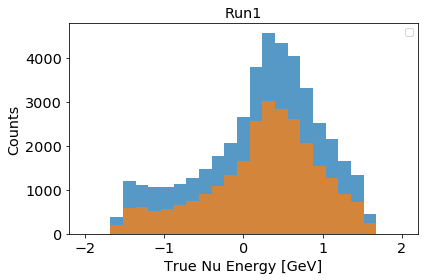

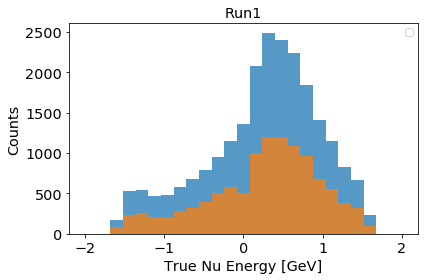

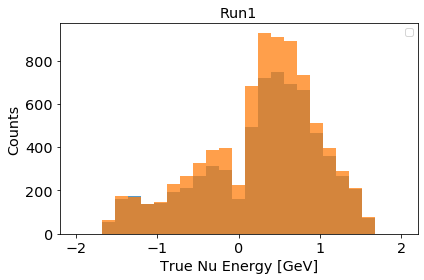

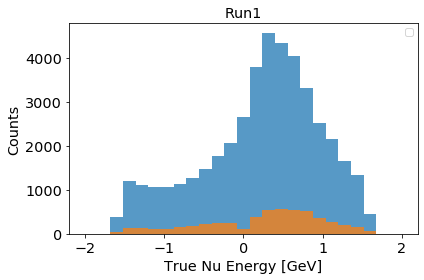

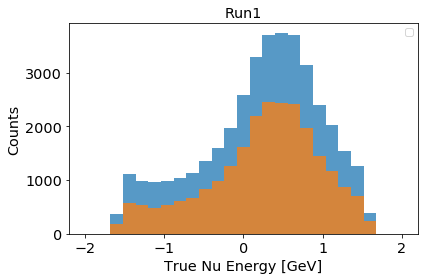

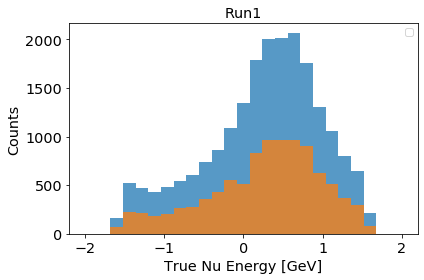

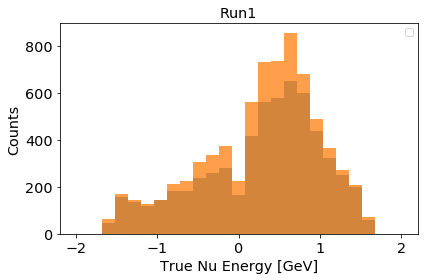

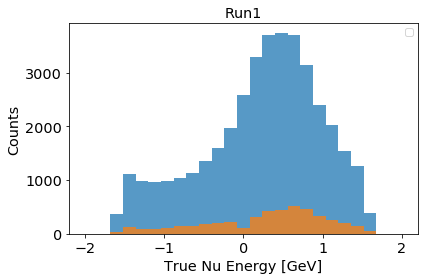

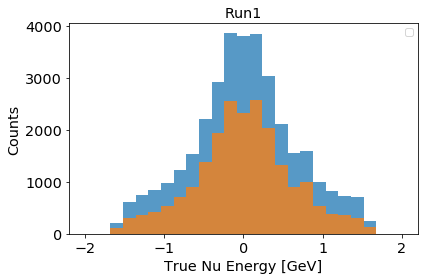

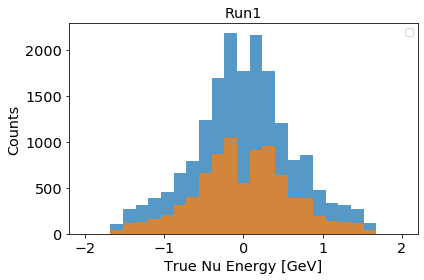

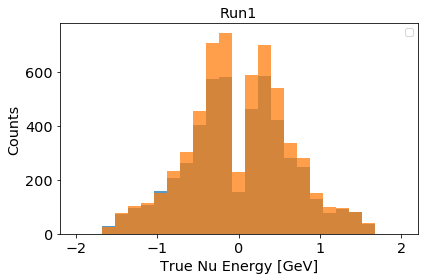

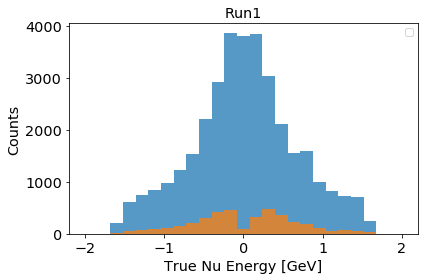

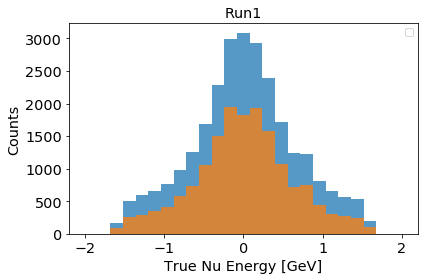

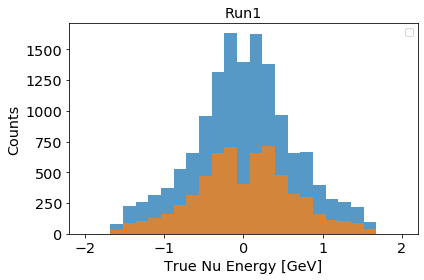

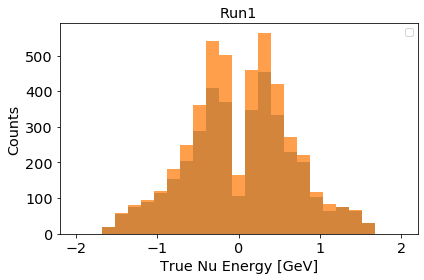

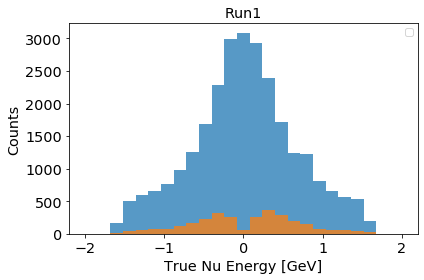

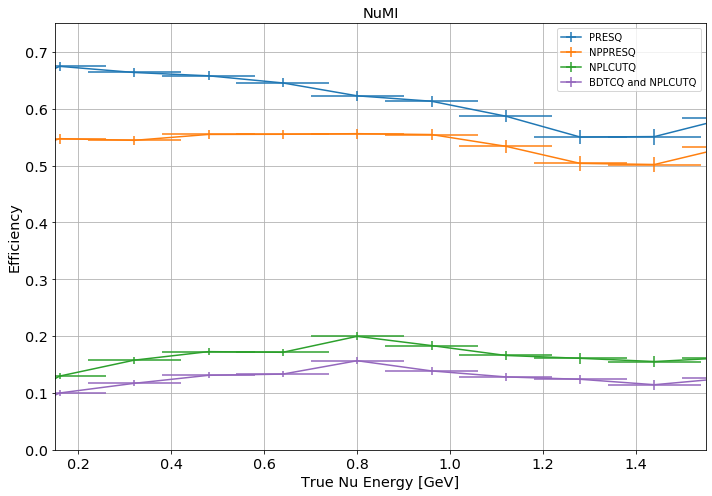

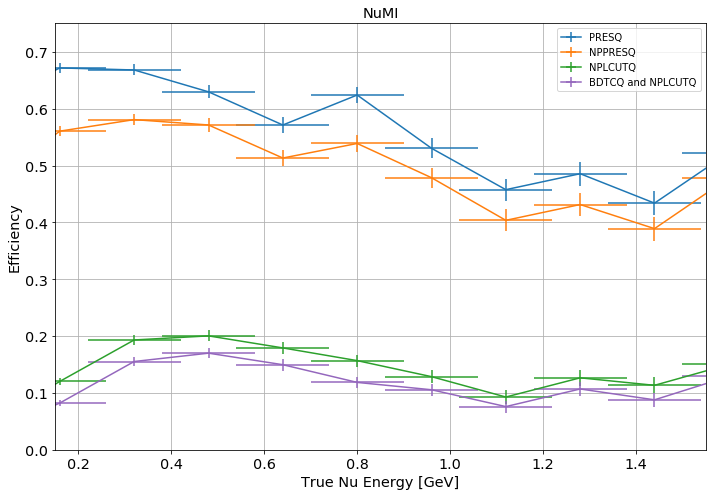

In [36]:
# NuMI plots
n_f_numi         , n_f_numi_PRESQ   , bins = histoPlot(f_numi        , f_numi_PRESQ,'el_thetaXZ')
n_f_numi_NPPRESQ , n_f_numi_NPVLCUTQ, bins = histoPlot(f_numi_NPPRESQ, f_numi_NPVLCUTQ,'el_thetaXZ')
n_f_numi_NPLCUTQ , n_f_numi_BDTCQ   , bins = histoPlot(f_numi_NPLCUTQ, f_numi_BDTCQ,'el_thetaXZ')
n_f_numi         , n_f_numi_Final   , bins = histoPlot(f_numi        , f_numi_Final,'el_thetaXZ')



un_f_numi         , un_f_numi_PRESQ   , bins = histoPlot(f_numi        , f_numi_PRESQ    ,'el_thetaXZ', False)
un_f_numi_NPPRESQ , un_f_numi_NPVLCUTQ, bins = histoPlot(f_numi_NPPRESQ, f_numi_NPVLCUTQ ,'el_thetaXZ', False)
un_f_numi_NPLCUTQ , un_f_numi_BDTCQ   , bins = histoPlot(f_numi_NPLCUTQ, f_numi_BDTCQ    ,'el_thetaXZ', False)
un_f_numi         , un_f_numi_Final   , bins = histoPlot(f_numi        , f_numi_Final    ,'el_thetaXZ', False)



# BNB plots
n_f_bnb         , n_f_bnb_PRESQ   , bins = histoPlot(f_bnb        , f_bnb_PRESQ   ,'el_thetaXZ',True,False)
n_f_bnb_NPPRESQ , n_f_bnb_NPVLCUTQ, bins = histoPlot(f_bnb_NPPRESQ, f_bnb_NPVLCUTQ,'el_thetaXZ',True,False)
n_f_bnb_NPLCUTQ , n_f_bnb_BDTCQ   , bins = histoPlot(f_bnb_NPLCUTQ, f_bnb_BDTCQ   ,'el_thetaXZ',True,False)
n_f_bnb         , n_f_bnb_Final   , bins = histoPlot(f_bnb        , f_bnb_Final   ,'el_thetaXZ',True,False)

un_f_bnb         , un_f_bnb_PRESQ   , bins = histoPlot(f_bnb        , f_bnb_PRESQ   ,'el_thetaXZ',False,False)
un_f_bnb_NPPRESQ , un_f_bnb_NPVLCUTQ, bins = histoPlot(f_bnb_NPPRESQ, f_bnb_NPVLCUTQ,'el_thetaXZ',False,False)
un_f_bnb_NPLCUTQ , un_f_bnb_BDTCQ   , bins = histoPlot(f_bnb_NPLCUTQ, f_bnb_BDTCQ   ,'el_thetaXZ',False,False)
un_f_bnb         , un_f_bnb_Final   , bins = histoPlot(f_bnb        , f_bnb_Final   ,'el_thetaXZ',False,False)

n1Sel_numi_v = [n_f_numi_PRESQ, n_f_numi_NPPRESQ , n_f_numi_NPLCUTQ, n_f_numi_Final  ]
un1Sel_numi_v = [un_f_numi_PRESQ, un_f_numi_NPPRESQ , un_f_numi_NPLCUTQ, un_f_numi_Final  ]

labels  = ["PRESQ", "NPPRESQ", "NPLCUTQ", "BDTCQ and NPLCUTQ"]

ratioPlotsWeight(n_f_numi, n1Sel_numi_v, un_f_numi, un1Sel_numi_v, labels,bins)

n1Sel_bnb_v = [n_f_bnb_PRESQ, n_f_bnb_NPPRESQ , n_f_bnb_NPLCUTQ, n_f_bnb_Final  ]
un1Sel_bnb_v = [un_f_bnb_PRESQ, un_f_bnb_NPPRESQ , un_f_bnb_NPLCUTQ, un_f_bnb_Final  ]

labels  = ["PRESQ", "NPPRESQ", "NPLCUTQ", "BDTCQ and NPLCUTQ"]
colors  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

ratioPlotsWeight(n_f_bnb, n1Sel_bnb_v, un_f_bnb, un1Sel_bnb_v, labels,bins)


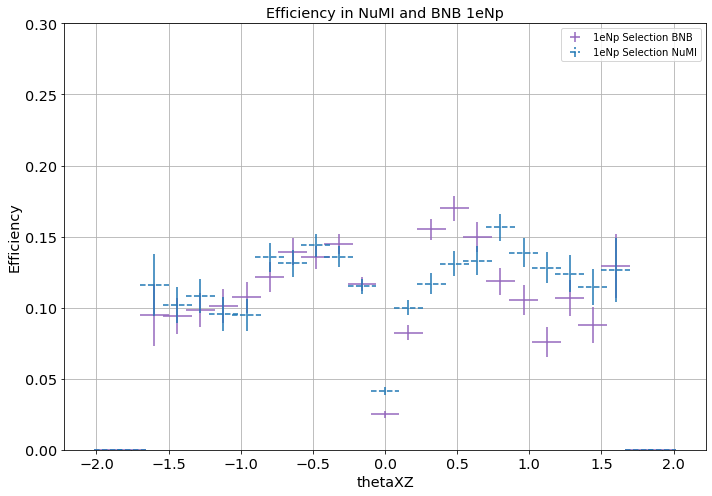

In [37]:
n1Sel_numi_v2  = [ n_f_numi_Final  ]
un1Sel_numi_v2 = [ un_f_numi_Final  ]
n1Sel_bnb_v2   = [ n_f_bnb_Final  ]
un1Sel_bnb_v2  = [ un_f_bnb_Final  ]

labels  = [ "1eNp Selection"]
colors  = ['tab:purple']
ratioAllPlotsWeight(n_f_bnb, n1Sel_bnb_v2, un_f_bnb, un1Sel_bnb_v2, n_f_numi, n1Sel_numi_v2, un_f_numi, un1Sel_numi_v2,labels,bins,colors,"Efficiency","thetaXZ")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


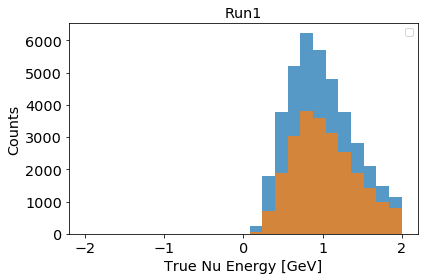

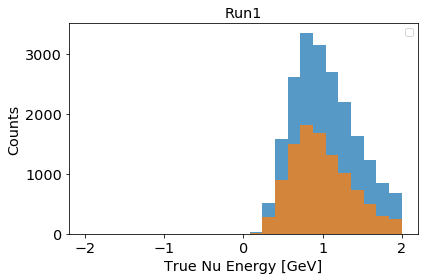

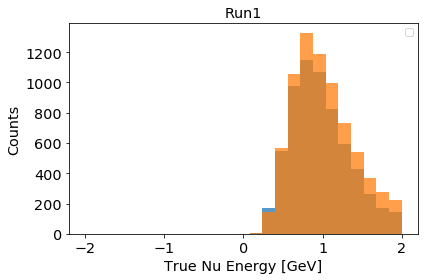

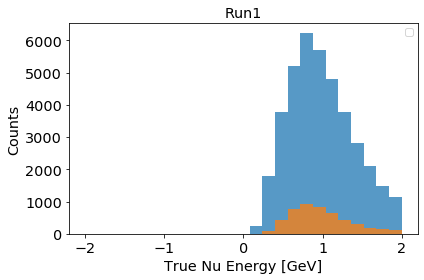

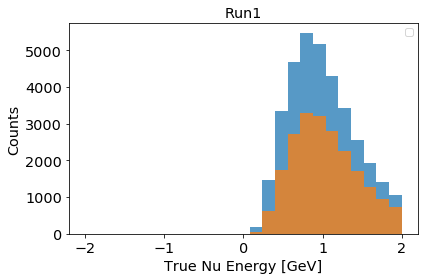

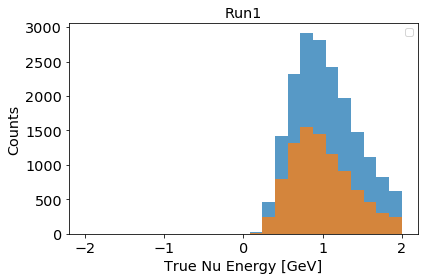

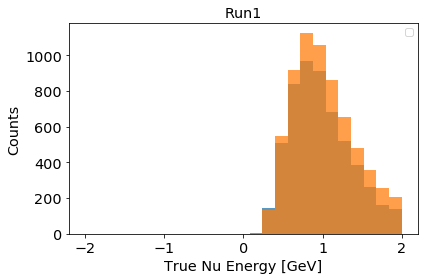

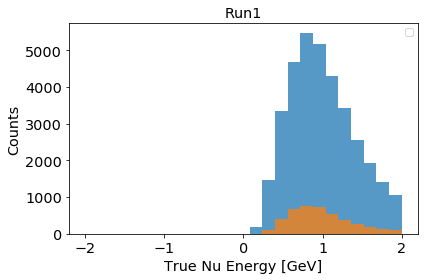

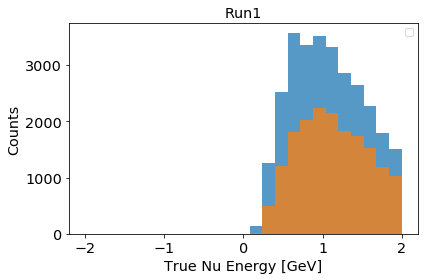

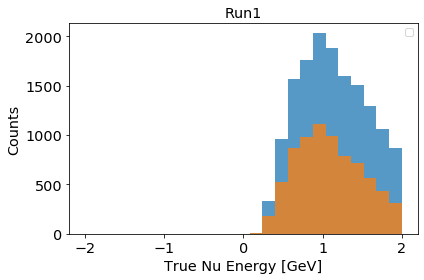

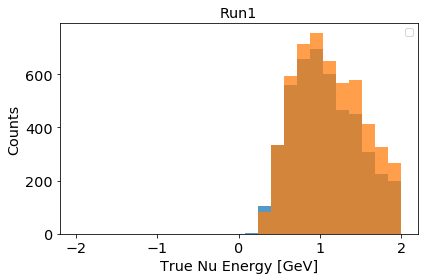

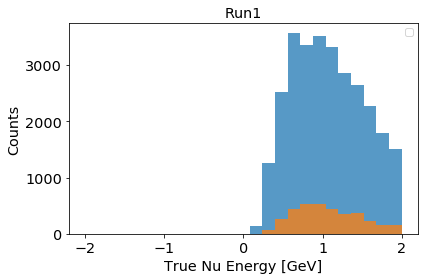

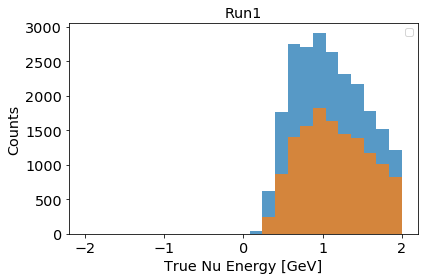

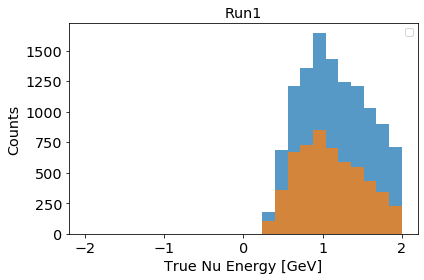

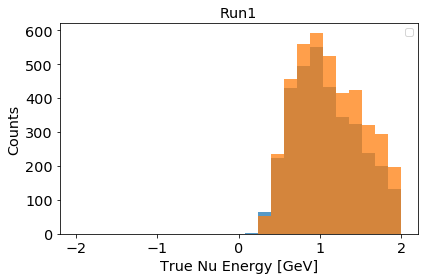

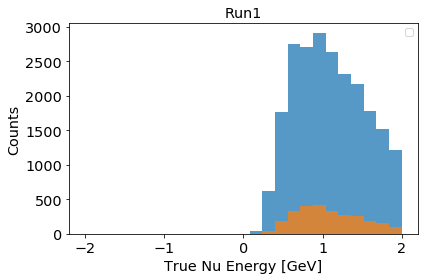

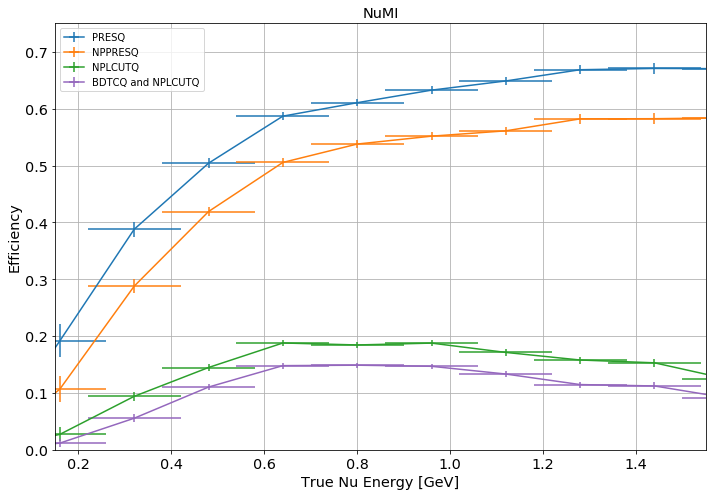

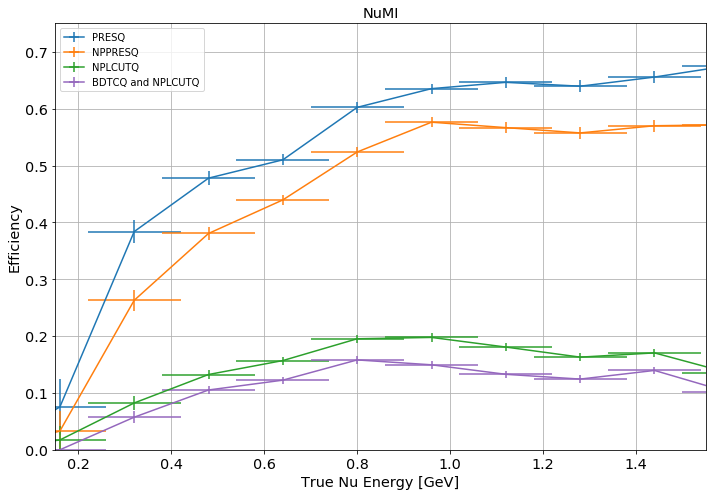

In [38]:
# NuMI plots
var = 'nu_e'
n_f_numi         , n_f_numi_PRESQ   , bins = histoPlot(f_numi        , f_numi_PRESQ,var)
n_f_numi_NPPRESQ , n_f_numi_NPVLCUTQ, bins = histoPlot(f_numi_NPPRESQ, f_numi_NPVLCUTQ,var)
n_f_numi_NPLCUTQ , n_f_numi_BDTCQ   , bins = histoPlot(f_numi_NPLCUTQ, f_numi_BDTCQ,var)
n_f_numi         , n_f_numi_Final   , bins = histoPlot(f_numi        , f_numi_Final,var)



un_f_numi         , un_f_numi_PRESQ   , bins = histoPlot(f_numi        , f_numi_PRESQ    ,var, False)
un_f_numi_NPPRESQ , un_f_numi_NPVLCUTQ, bins = histoPlot(f_numi_NPPRESQ, f_numi_NPVLCUTQ ,var, False)
un_f_numi_NPLCUTQ , un_f_numi_BDTCQ   , bins = histoPlot(f_numi_NPLCUTQ, f_numi_BDTCQ    ,var, False)
un_f_numi         , un_f_numi_Final   , bins = histoPlot(f_numi        , f_numi_Final    ,var, False)



# BNB plots
n_f_bnb         , n_f_bnb_PRESQ   , bins = histoPlot(f_bnb        , f_bnb_PRESQ   ,var,True,False)
n_f_bnb_NPPRESQ , n_f_bnb_NPVLCUTQ, bins = histoPlot(f_bnb_NPPRESQ, f_bnb_NPVLCUTQ,var,True,False)
n_f_bnb_NPLCUTQ , n_f_bnb_BDTCQ   , bins = histoPlot(f_bnb_NPLCUTQ, f_bnb_BDTCQ   ,var,True,False)
n_f_bnb         , n_f_bnb_Final   , bins = histoPlot(f_bnb        , f_bnb_Final   ,var,True,False)

un_f_bnb         , un_f_bnb_PRESQ   , bins = histoPlot(f_bnb        , f_bnb_PRESQ   ,var,False,False)
un_f_bnb_NPPRESQ , un_f_bnb_NPVLCUTQ, bins = histoPlot(f_bnb_NPPRESQ, f_bnb_NPVLCUTQ,var,False,False)
un_f_bnb_NPLCUTQ , un_f_bnb_BDTCQ   , bins = histoPlot(f_bnb_NPLCUTQ, f_bnb_BDTCQ   ,var,False,False)
un_f_bnb         , un_f_bnb_Final   , bins = histoPlot(f_bnb        , f_bnb_Final   ,var,False,False)

n1Sel_numi_v = [n_f_numi_PRESQ, n_f_numi_NPPRESQ , n_f_numi_NPLCUTQ, n_f_numi_Final  ]
un1Sel_numi_v = [un_f_numi_PRESQ, un_f_numi_NPPRESQ , un_f_numi_NPLCUTQ, un_f_numi_Final  ]

labels  = ["PRESQ", "NPPRESQ", "NPLCUTQ", "BDTCQ and NPLCUTQ"]

ratioPlotsWeight(n_f_numi, n1Sel_numi_v, un_f_numi, un1Sel_numi_v, labels,bins)

n1Sel_bnb_v = [n_f_bnb_PRESQ, n_f_bnb_NPPRESQ , n_f_bnb_NPLCUTQ, n_f_bnb_Final  ]
un1Sel_bnb_v = [un_f_bnb_PRESQ, un_f_bnb_NPPRESQ , un_f_bnb_NPLCUTQ, un_f_bnb_Final  ]

labels  = ["PRESQ", "NPPRESQ", "NPLCUTQ", "BDTCQ and NPLCUTQ"]
colors  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

ratioPlotsWeight(n_f_bnb, n1Sel_bnb_v, un_f_bnb, un1Sel_bnb_v, labels,bins)


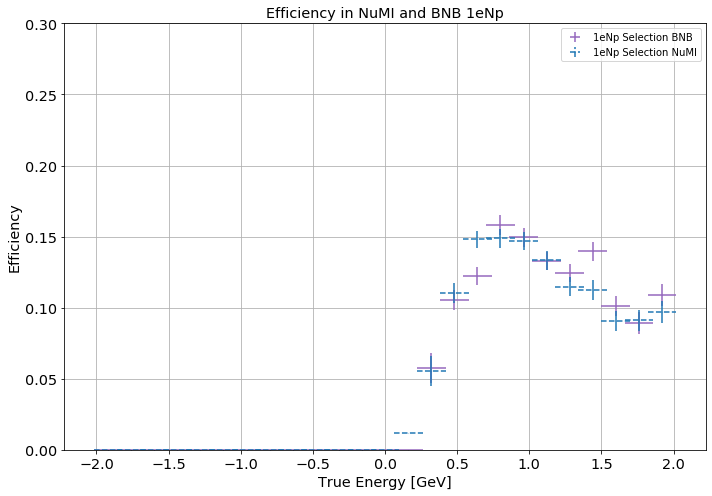

In [39]:
n1Sel_numi_v2  = [ n_f_numi_Final  ]
un1Sel_numi_v2 = [ un_f_numi_Final  ]
n1Sel_bnb_v2   = [ n_f_bnb_Final  ]
un1Sel_bnb_v2  = [ un_f_bnb_Final  ]

labels  = [ "1eNp Selection"]
colors  = ['tab:purple']
ratioAllPlotsWeight(n_f_bnb, n1Sel_bnb_v2, un_f_bnb, un1Sel_bnb_v2, n_f_numi, n1Sel_numi_v2, un_f_numi, un1Sel_numi_v2,labels,bins,colors,"Efficiency","True Energy [GeV]")


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


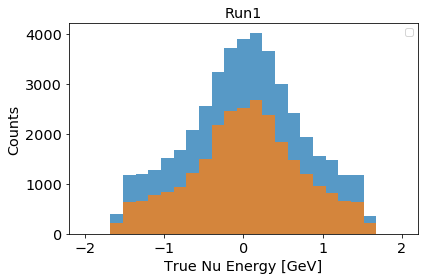

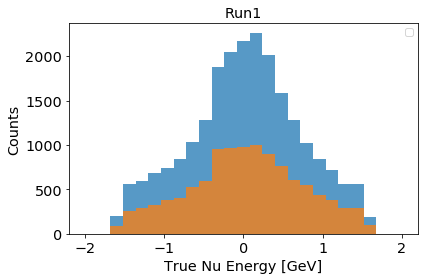

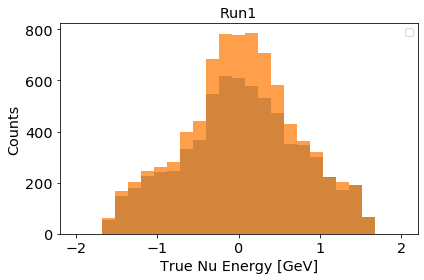

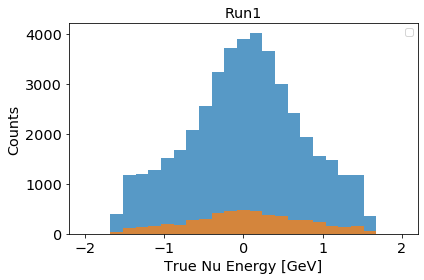

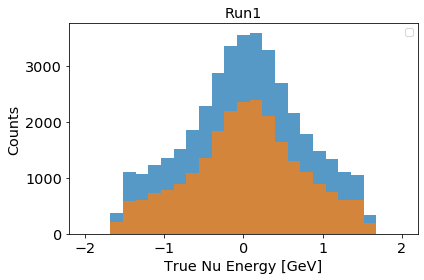

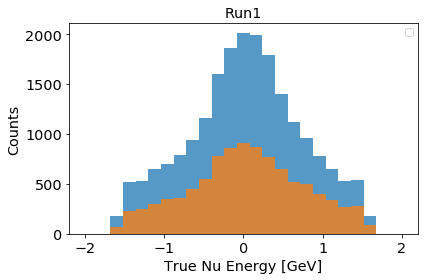

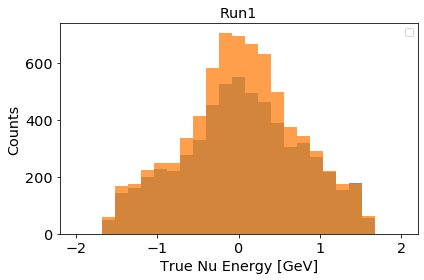

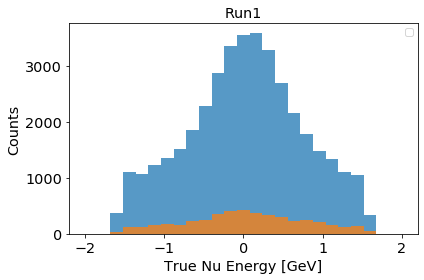

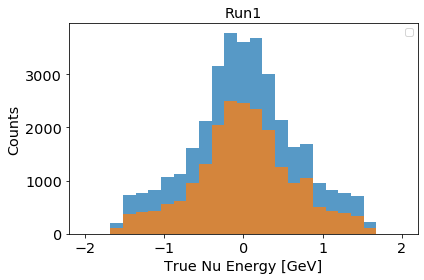

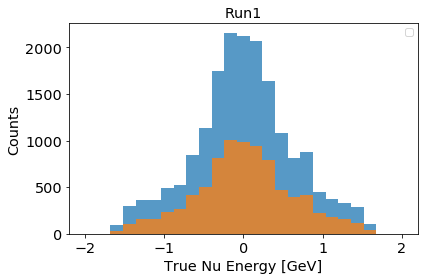

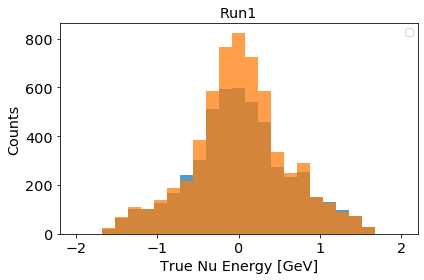

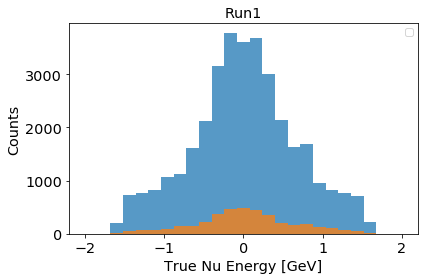

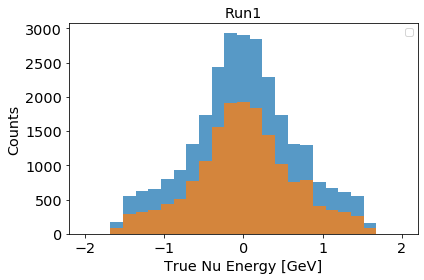

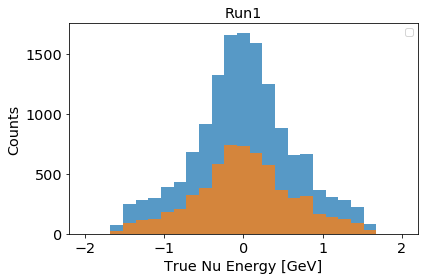

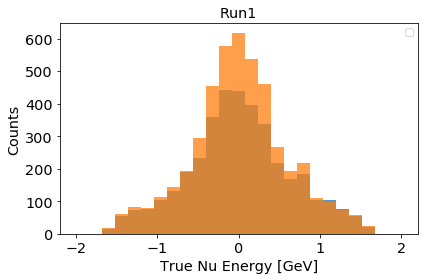

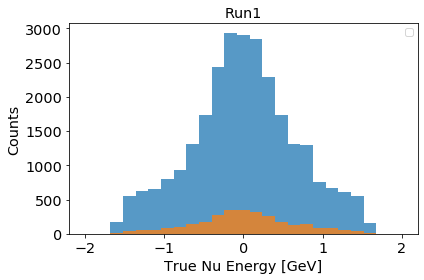

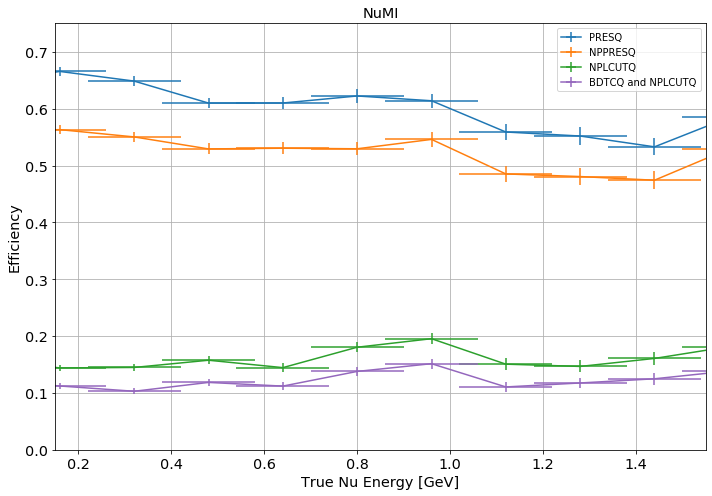

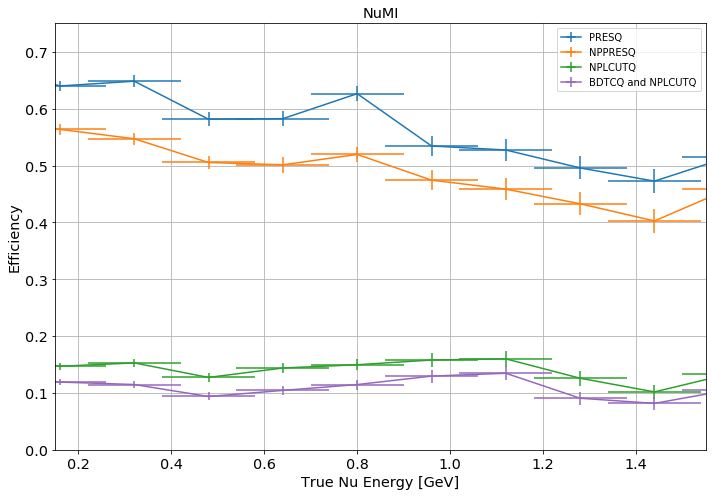

In [40]:
# NuMI plots
n_f_numi         , n_f_numi_PRESQ   , bins = histoPlot(f_numi        , f_numi_PRESQ,'el_thetaYZ')
n_f_numi_NPPRESQ , n_f_numi_NPVLCUTQ, bins = histoPlot(f_numi_NPPRESQ, f_numi_NPVLCUTQ,'el_thetaYZ')
n_f_numi_NPLCUTQ , n_f_numi_BDTCQ   , bins = histoPlot(f_numi_NPLCUTQ, f_numi_BDTCQ,'el_thetaYZ')
n_f_numi         , n_f_numi_Final   , bins = histoPlot(f_numi        , f_numi_Final,'el_thetaYZ')



un_f_numi         , un_f_numi_PRESQ   , bins = histoPlot(f_numi        , f_numi_PRESQ    ,'el_thetaYZ', False)
un_f_numi_NPPRESQ , un_f_numi_NPVLCUTQ, bins = histoPlot(f_numi_NPPRESQ, f_numi_NPVLCUTQ ,'el_thetaYZ', False)
un_f_numi_NPLCUTQ , un_f_numi_BDTCQ   , bins = histoPlot(f_numi_NPLCUTQ, f_numi_BDTCQ    ,'el_thetaYZ', False)
un_f_numi         , un_f_numi_Final   , bins = histoPlot(f_numi        , f_numi_Final    ,'el_thetaYZ', False)



# BNB plots
n_f_bnb         , n_f_bnb_PRESQ   , bins = histoPlot(f_bnb        , f_bnb_PRESQ   ,'el_thetaYZ',True,False)
n_f_bnb_NPPRESQ , n_f_bnb_NPVLCUTQ, bins = histoPlot(f_bnb_NPPRESQ, f_bnb_NPVLCUTQ,'el_thetaYZ',True,False)
n_f_bnb_NPLCUTQ , n_f_bnb_BDTCQ   , bins = histoPlot(f_bnb_NPLCUTQ, f_bnb_BDTCQ   ,'el_thetaYZ',True,False)
n_f_bnb         , n_f_bnb_Final   , bins = histoPlot(f_bnb        , f_bnb_Final   ,'el_thetaYZ',True,False)

un_f_bnb         , un_f_bnb_PRESQ   , bins = histoPlot(f_bnb        , f_bnb_PRESQ   ,'el_thetaYZ',False,False)
un_f_bnb_NPPRESQ , un_f_bnb_NPVLCUTQ, bins = histoPlot(f_bnb_NPPRESQ, f_bnb_NPVLCUTQ,'el_thetaYZ',False,False)
un_f_bnb_NPLCUTQ , un_f_bnb_BDTCQ   , bins = histoPlot(f_bnb_NPLCUTQ, f_bnb_BDTCQ   ,'el_thetaYZ',False,False)
un_f_bnb         , un_f_bnb_Final   , bins = histoPlot(f_bnb        , f_bnb_Final   ,'el_thetaYZ',False,False)

n1Sel_numi_v = [n_f_numi_PRESQ, n_f_numi_NPPRESQ , n_f_numi_NPLCUTQ, n_f_numi_Final  ]
un1Sel_numi_v = [un_f_numi_PRESQ, un_f_numi_NPPRESQ , un_f_numi_NPLCUTQ, un_f_numi_Final  ]

labels  = ["PRESQ", "NPPRESQ", "NPLCUTQ", "BDTCQ and NPLCUTQ"]

ratioPlotsWeight(n_f_numi, n1Sel_numi_v, un_f_numi, un1Sel_numi_v, labels,bins)

n1Sel_bnb_v = [n_f_bnb_PRESQ, n_f_bnb_NPPRESQ , n_f_bnb_NPLCUTQ, n_f_bnb_Final  ]
un1Sel_bnb_v = [un_f_bnb_PRESQ, un_f_bnb_NPPRESQ , un_f_bnb_NPLCUTQ, un_f_bnb_Final  ]

labels  = ["PRESQ", "NPPRESQ", "NPLCUTQ", "BDTCQ and NPLCUTQ"]
colors  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

ratioPlotsWeight(n_f_bnb, n1Sel_bnb_v, un_f_bnb, un1Sel_bnb_v, labels,bins)


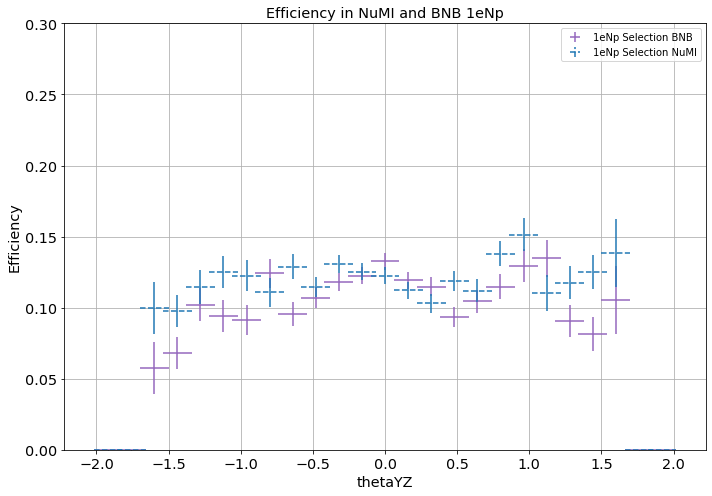

In [41]:
n1Sel_numi_v2  = [ n_f_numi_Final  ]
un1Sel_numi_v2 = [ un_f_numi_Final  ]
n1Sel_bnb_v2   = [ n_f_bnb_Final  ]
un1Sel_bnb_v2  = [ un_f_bnb_Final  ]

labels  = [ "1eNp Selection"]
colors  = ['tab:purple']
ratioAllPlotsWeight(n_f_bnb, n1Sel_bnb_v2, un_f_bnb, un1Sel_bnb_v2, n_f_numi, n1Sel_numi_v2, un_f_numi, un1Sel_numi_v2,labels,bins,colors,"Efficiency","thetaYZ")


NuMI Median =  546.7778537633366  m/GeV
BNB  Median =  330.44046  m/GeV
NuMI Integral =  3086.323133468628
BNB  Integral =  1288.4006101666018


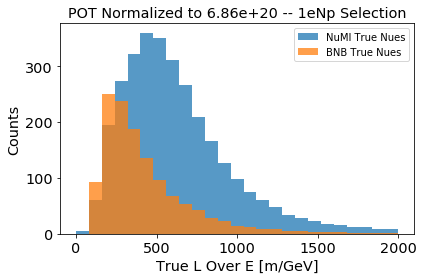

In [42]:
ACCEPTANCE   = 'isVtxInFiducial == 1 and truthFiducial == 1 and ccnc>=0 and npi0==0 and npion==0'
ACCEPTANCENP = ACCEPTANCE + ' and nproton > 0'
ACCEPTANCEZP = ACCEPTANCE + ' and nproton == 0'

QUERY = ACCEPTANCE
QUERY = "nu_pdg==12"#+" and "+NPLCUTQ +" and "+ BDTCQ 

f_numi = numi.query(QUERY)[["nu_e","interaction","nu_pdg","flux","weightSplineTimesTuneTimesPPFX","LOverE"]]
f_bnb  = bnb.query(QUERY)[["nu_e","interaction","nu_pdg","flux","weightSplineTimesTune","LOverE"]]


s1 = f_numi['LOverE'] #nu_pdg
s3 = f_bnb['LOverE']
print("NuMI Median = ", np.median(s1)," m/GeV")
print("BNB  Median = ", np.median(s3)," m/GeV")
#s1_anti = f_numi.query()['nu_e']
#s3_anti = f_bnb['nu_e']

fig, ax = plt.subplots()
NumiNorm = 6.86e+20/2.37425e+22 
BNBNorm  = 6.86e+20/5.25E+22
w1 = f_numi['weightSplineTimesTuneTimesPPFX']*NumiNorm
w3 = f_bnb ['weightSplineTimesTune']*BNBNorm


n1_0, bins, patches = ax.hist(s1, 25,range=(0.,2000.0),weights=w1,density=True, alpha=0.75,label="NuMI True Nues")
n3_0, bins, patches = ax.hist(s3, 25,range=(0.,2000.0),weights=w3,density=True, alpha=0.75,label="BNB True Nues")

#n1_0, bins, patches = ax.hist(s1, 40,range=(0.,8.0),weights=w1,density=True, alpha=0.75,label="NuMI True Nues")
#n3_0, bins, patches = ax.hist(s3, 40,range=(0.,8.0),weights=w3,density=True, alpha=0.75,label="BNB True Nues")
#print(n1_0)
normNuMI  = n1_0.sum()
normBNB   = n3_0.sum()
print("NuMI Integral = ", normNuMI)
print("BNB  Integral = ", normBNB)


#ax.set_xlabel('True Nu Energy [GeV]')
ax.set_xlabel('True L Over E [m/GeV]')
ax.set_ylabel('Counts')
ax.set_title('POT Normalized to 6.86e+20-- No Selection')
ax.set_title('POT Normalized to 6.86e+20 -- 1eNp Selection')
ax.legend()
fig.tight_layout()


In [ ]:
ACCEPTANCE   = 'isVtxInFiducial == 1 and truthFiducial == 1 and ccnc>=0 and npi0==0 and npion==0'
ACCEPTANCENP = ACCEPTANCE + ' and nproton > 0'
ACCEPTANCEZP = ACCEPTANCE + ' and nproton == 0'

QUERY = ACCEPTANCE
QUERY = "nu_pdg==12"+" and "+NPLCUTQ +" and "+ BDTCQ 

f_numi = numi.query(QUERY)[["nu_e","interaction","nu_pdg","flux","weightSplineTimesTuneTimesPPFX","LOverE"]]
f_bnb  = bnb.query(QUERY)[["nu_e","interaction","nu_pdg","flux","weightSplineTimesTune","LOverE"]]


s1 = f_numi['nu_e'] #nu_pdg
s3 = f_bnb['nu_e']
print("NuMI Median = ", np.median(s1)," m/GeV")
print("BNB  Median = ", np.median(s3)," m/GeV")
#s1_anti = f_numi.query()['nu_e']
#s3_anti = f_bnb['nu_e']

fig, ax = plt.subplots()
NumiNorm = 6.86e+20/2.37425e+22 
BNBNorm  = 6.86e+20/5.25E+22
w1 = f_numi['weightSplineTimesTuneTimesPPFX']*NumiNorm
w3 = f_bnb ['weightSplineTimesTune']*BNBNorm


n1_0, bins, patches = ax.hist(s1, 25,range=(0.,4.0),weights=w1,density=False, alpha=0.75,label="NuMI True Nues")
n3_0, bins, patches = ax.hist(s3, 25,range=(0.,4.0),weights=w3,density=False, alpha=0.75,label="BNB True Nues")

#n1_0, bins, patches = ax.hist(s1, 40,range=(0.,8.0),weights=w1,density=True, alpha=0.75,label="NuMI True Nues")
#n3_0, bins, patches = ax.hist(s3, 40,range=(0.,8.0),weights=w3,density=True, alpha=0.75,label="BNB True Nues")
#print(n1_0)
normNuMI  = n1_0.sum()
normBNB   = n3_0.sum()
print("NuMI Integral = ", normNuMI)
print("BNB  Integral = ", normBNB)


#ax.set_xlabel('True Nu Energy [GeV]')
ax.set_xlabel('True E [GeV]')
ax.set_ylabel('Counts')
ax.set_title('POT Normalized to 6.86e+20-- No Selection')
ax.set_title('POT Normalized to 6.86e+20 -- 1eNp Selection')
ax.legend()
fig.tight_layout()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
sysBool = False
#+ " and run <= 6747" 

QUERY = "nu_pdg==-12"

#QUERY = PRESQ
VARIABLE, BINS, RANGE, XTIT = 'nu_e', 25, (0.,6.0), r"True Nue Energy [GeV]"
kind = "event_category"
kind = "interaction"
kind = "flux"


fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query= QUERY ,
    kind=kind,
    draw_sys  = sysBool, 
    draw_geoSys = sysBool, 
    draw_data = False,#True,
    genieweight = "weightSplineTimesTuneTimesPPFX", #"weightSplineTimesTuneTimesPPFX", 
    stacksort=3,
    ratio=False,
    title=XTIT,
    bins=BINS,
    range=RANGE
)[0:3]

ax1.set_title('NuMI Run 1, AntiNues, No Selection',loc='left')
fig.tight_layout()
#fig.savefig("/Users/elenag/Desktop/PlotterLEE/plots/TrueNues/"+VARIABLE+"_NuMI_run1_AllRecoE_"+kind+"_NueBars.pdf")
